# Regression with Random Forest Regressor 

This notebook contains the regression part of the project, where we try to predict the number of tweets for December 31st, given the features of that day.

![random-forest.jpg](random-forest.jpg)

We start by importing all the necessary libraries and by loading the data 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ydata_profiling
from ydata_profiling import ProfileReport

from shapely import wkt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Preparing data

We import the data from `TWER_grouped.csv` beacuse we don't need classes here.

In [2]:
df = pd.read_csv("../data/processed/TWER_grouped.csv")

In [3]:
df = df.drop(['Unnamed: 0'], axis=1)

In [4]:
df.head()

,date,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,population,elevation,tweet_count,month,day,day_of_week
0,2013-11-01,Andalo,A,9.200000,8.5,12.000000,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,1,11,1,4
1,2013-11-01,Baselga di Pinè,B,11.533333,8.0,13.733333,0.0,0.2,236.0,5.996413,0.016458,4928.0,964.0,3,11,1,4
2,2013-11-01,Baselga di Pinè,C,11.433333,7.3,12.966667,0.0,0.0,184.0,10.637787,0.017426,4928.0,964.0,3,11,1,4
3,2013-11-01,Baselga di Pinè,D,9.350000,6.6,12.200000,0.0,NaN,NaN,18.809585,0.024556,4928.0,964.0,2,11,1,4
4,2013-11-01,Bedollo,B,14.120000,8.7,14.500000,0.0,0.3,232.5,0.383955,0.015358,1476.0,1059.0,5,11,1,4


Before continuing, we need to remove the last day (2013-12-31), on which we will make the prediction.

In [5]:
df = df[df['day'] != 31]

Then we define the features and the target (different from classification):

In [6]:
X = df.drop('tweet_count', axis=1)
y = df['tweet_count']

### Preprocessing

We now preprocess the data: first, we need to separate the features in numerical and categorical

In [7]:
categorical_features = ['date', 'municipality.name', 'hour_category', 'month', 'day_of_week']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'wind_speed',
                      'wind_dir',
                      'curr_cell',
                      'population',
                      'elevation',
                      'curr_site',
                      'day']

Second, we enconde the categorical data with label encoding

In [8]:
le = LabelEncoder()
for feat in categorical_features:
    X[feat] = le.fit_transform(X[feat])

We then scale the numerical features, convert them back to dataframe form and finally recombine categorical and numerical data

In [9]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_features])

In [10]:
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

In [11]:
X = pd.concat([scaled_numerical_df, X[categorical_features].astype('category')], axis=1)

The result is 

In [12]:
X.head()

,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,population,elevation,curr_site,day,date,municipality.name,hour_category,month,day_of_week
0,1.359660,2.083997,1.183481,-0.236583,NaN,NaN,-0.547011,-0.368773,0.952868,-0.358125,-1.760071,0,4,0,0,4
1,1.910475,1.960059,1.636554,-0.236583,-0.806376,0.438802,-0.212064,-0.211177,0.742049,-0.254979,-1.760071,0,6,1,0,4
2,1.886869,1.786544,1.436156,-0.236583,-0.990016,-0.104575,0.047193,-0.211177,0.742049,-0.248914,-1.760071,0,6,2,0,4
3,1.395069,1.613030,1.235759,-0.236583,NaN,NaN,0.503653,-0.211177,0.742049,-0.204231,-1.760071,0,6,3,0,4
4,2.521093,2.133573,1.836952,-0.236583,-0.714557,0.402229,-0.525564,-0.350527,0.998816,-0.261873,-1.760071,0,7,1,0,4


## RF regression

We now proceed to implement our regressor, first we split the data into train dataset and test dataset 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Then we initialise and train the random forest. We decide to not limit the depth, since the training time is not high.

In [14]:
# initialize 
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# train 
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

We then calculate the predictions on the test:

In [15]:
y_pred = rf_regressor.predict(X_test)

Then we evaluate the model by calculating some meaningful estimators ($\text{MAE}$, $R^2$, $\text{MSE}$)

In [16]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
print(f"Mean Square Error: {mse}")

# average tweet count Trentino
average_tweet_count_trentino = df['tweet_count'].mean()

print(f"Average tweet count for the whole of Trentino: {average_tweet_count_trentino}")

# Predict on the entire dataset and store the predictions in the DataFrame
df['predicted_tweet_count'] = rf_regressor.predict(X)

Mean Absolute Error: 3.4363794871794875
R² Score: 0.5291908718735647
Mean Square Error: 60.52781384615384
Average tweet count for the whole of Trentino: 5.535494460402134


The mean absolute error illustrates that the typical error we can expect from tweetcount prediction is of 3-4 tweets. 

Unfortunatly, given that most municipalities have a tweet count around 5-6 this is really not good. 
The $R^2$ factor is indeed just fair, we are certain we are missing important factors which influence the number of tweeters.

In the classification notebook we verified that a social, scheduled (and therefore predictable) event such as the **Universiadi** caused a major misprediction. From the regression we can verify that the actual absolute error is $\sim 87$. 
It is clear that in order to be quantitative, in order to reliably predict the social pulse we should be able to complete the dataframe with **local events**, specific **holidays** and major **news** events. Since this is the only available dataframe for us, we conclude that this type of survey is really just fit for classification.

Just not to be tragic or drastic, we signal that this huge $\text{MAE}$ may be driven mainly by the very high peaks, such as the ones that have been recorded on Dec 13th and 14th; this possibility is higlighted by the very high value of $\text{MSE}$, that adds up the square of the errors, since this is way larger that the square of mean absolute error, occasional peaks are something to consider appropriately. 

If we remove the peaks: 

In [17]:
# Create a new column for the difference between predicted and actual tweet counts
df['tweet_difference'] = abs(df['predicted_tweet_count'] - df['tweet_count'])

#  Find the top 3 municipalities and timeslots with the greatest difference
top_3_diff = df.nlargest(3, 'tweet_difference')

# Print the top 3 municipalities and timeslots with the greatest differences
print("Top 3 municipalities and timeslots with the greatest difference in tweet counts:")
print(top_3_diff[['date', 'municipality.name', 'hour_category', 'tweet_count', 'predicted_tweet_count', 'tweet_difference']])

#  Remove  top 3 rows from the original DataFrame
df_without_top_3_diff = df.drop(top_3_diff.index)

#  Reset  DataFrame index
df_without_top_3_diff = df_without_top_3_diff.reset_index(drop=True)

#  Calculate average tweet count for the new dataset
average_tweet_count_new = df_without_top_3_diff['tweet_count'].mean()

#  Calculate the average mean error (Mean Absolute Error - MAE)
average_mean_error_new = abs(df_without_top_3_diff['predicted_tweet_count'] - df_without_top_3_diff['tweet_count']).mean()

# Print results 
print(f"Average tweet count for the new dataset: {average_tweet_count_new}")
print(f"MAE for the new dataset: {average_mean_error_new}")

Top 3 municipalities and timeslots with the greatest difference in tweet counts:
            date municipality.name hour_category  tweet_count  \
2153  2013-12-04            Trento             C          141   
3198  2013-12-15            Tesero             D           93   
937   2013-11-18          Rovereto             D           89   

      predicted_tweet_count  tweet_difference  
2153                  54.01             86.99  
3198                  18.66             74.34  
937                   15.08             73.92  
Average tweet count for the new dataset: 5.472592896735783
MAE for the new dataset: 1.6254116197905972


Indeed, just by removing the 3 worst predictions in a set of more than 5000 elements, the $\text{MAE}$ is more than halved. 


The potential error-related improvement in removing a few points is clearly visible in the following plot, where for very few points the tweet counts and the relative prediction diverge insanely. You can clearly see the 3 points we removed. 

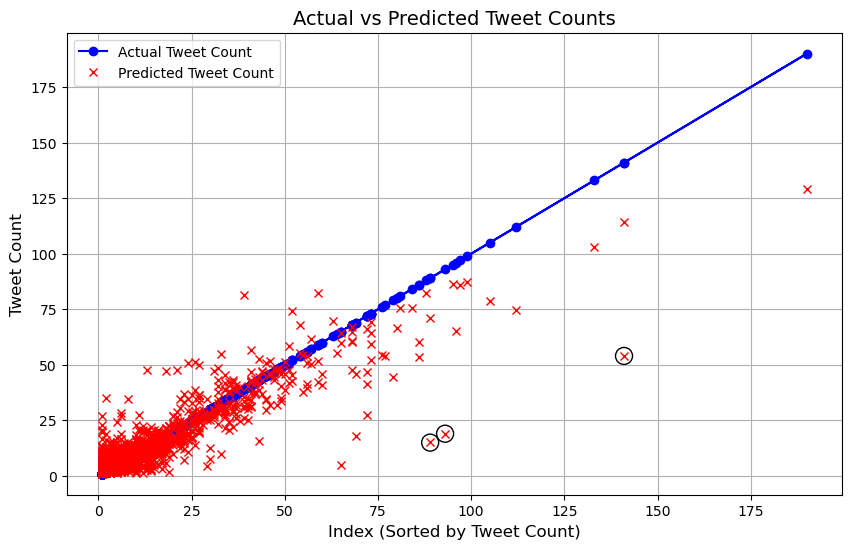

In [18]:
#  Plot the actual and predicted tweet counts
plt.figure(figsize=(10, 6))  # Set the figure size for better readability

# Plot actual tweet counts (blue solid line with circle markers)
plt.plot(df['tweet_count'], df['tweet_count'], label='Actual Tweet Count', color='blue', linestyle='-', marker='o')

# Plot predicted tweet counts (red solid line with x markers)
plt.plot(df['tweet_count'], df['predicted_tweet_count'], label='Predicted Tweet Count', color='red', linestyle=' ', marker='x')

# Highlight specific points (circle markers for these points)
highlight_points = [(141, 54), (93, 19), (89, 15)]
for point in highlight_points:
    plt.scatter(point[0], point[1], facecolors='none', edgecolor='black', s=150, zorder=5)

#  Add labels and a title
plt.xlabel('Index (Sorted by Tweet Count)', fontsize=12)
plt.ylabel('Tweet Count', fontsize=12)
plt.title('Actual vs Predicted Tweet Counts', fontsize=14)

# Legend to differentiate between the two lines
plt.legend()

# Add gridlines for better readability
plt.grid(True)

plt.show()

Nevertheless, we insist that without reliable data on social activities and events, this dataset is more fit for classification than for the  precise predictions of a regression. 

To conlude, by elaborating on the imbalanced nature of the dataset which the regression pointed out, it seemed meaningful to show how the distribution of tweets in the province is all but uniform, the division by municipalities corresponds to our desire to trace trends in all local municipalities of Trentino, but that is no "efficient approach" to trace overall activity, since, to very good approximation, the actual vast majority of social activities is happening in very, very few places. 

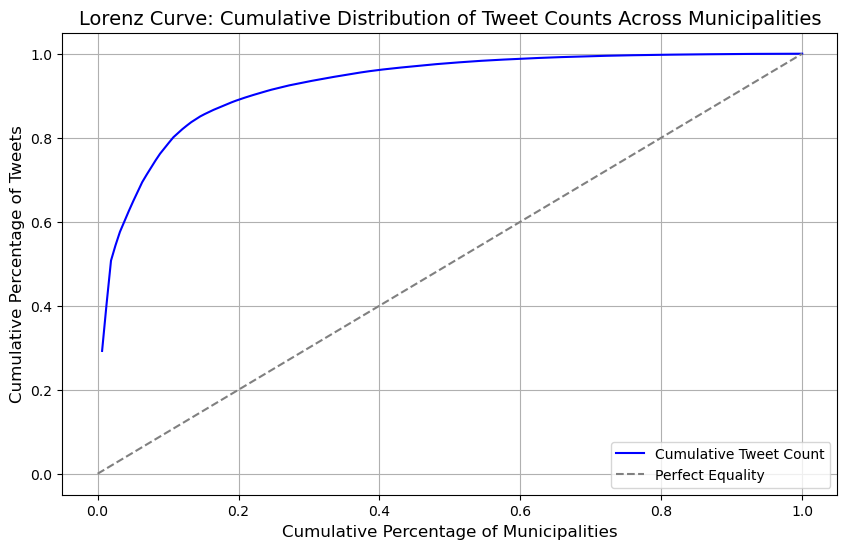

In [19]:
# sort municipalities by tweet count in descending order
df_sorted = df.groupby('municipality.name')['tweet_count'].sum().sort_values(ascending=False)

# calculate cumulative tweet count and cumulative percentage of municipalities
cumulative_tweets = df_sorted.cumsum()
cumulative_percentage_municipalities = np.arange(1, len(df_sorted)+1) / len(df_sorted)

# plot the Lorenz curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_percentage_municipalities, cumulative_tweets / cumulative_tweets.max(), label="Cumulative Tweet Count", color='blue')

# add a reference line (y = x) for perfect equality
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Equality')

# add labels and title
plt.title('Lorenz Curve: Cumulative Distribution of Tweet Counts Across Municipalities', fontsize=14)
plt.xlabel('Cumulative Percentage of Municipalities', fontsize=12)
plt.ylabel('Cumulative Percentage of Tweets', fontsize=12)

# add a legend and grid
plt.legend()
plt.grid(True)

If the bisector represents perfect equality in the contribution of the municipalities/timeslot classes to tweeting, we see that the distribution is indeed very imbalaced. The two most meaningful insights are that one class accounts for around 30% of the activity and  that 20% of the classes account for more than 90% of the activity. 

Eventually this can give a profound justification for the fact that few peaks account for much of the $\text{MAE}$. 
The fact of imbalanced distribution is not per se an indicator of how the $\text{MAE}$ compares with the average tweet count: if the relative error of the bigger cities is the same, the fact of having 30% or even potentially 90% of the tweets does not affect the $\text{MAE}$. But the matter is totally different if we assume that bigger municipalities are more subjected to extreme and unpredicted events than little municipalities, more specifically, if we assume that complexity and stochastic events increase more than linearly with population! This makes all the difference: if tweets are prevalently created in few bigger municipalities at some given hours and these municipalities tend to behave way more unpredictably, this indeed drives to the conclusion that few peaks will make for most of the $\text{MAE}$.

<!--
Such an assumption may seem couterintuitive for a person eager to describe society with gaussian models, where larger samples are less prone to unpredictability, but it has been recently  widely argued that in complex ecosystems, such as cities, the behaviour  is much more fuzzy and the gaussian does not hold at all, instead power laws with exponents greater than 1 work way better. 
This final reflexion is inspired by the work of Nassim Nicholas Taleb , "the Black Swan", Penguin Books, 2017. 
The arguments and evidence reported can be found in chapters 3, 13, 14, 15, along with an extensive bibliography.
-->  

## Prediction

Now that we estalished the validity of our model, we can train it on all data before December 31st, the day of the prediction.

In [20]:
df = pd.read_csv('../data/processed/TWER_grouped.csv').drop('Unnamed: 0', axis=1)

In [21]:
df.head()

,date,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,population,elevation,tweet_count,month,day,day_of_week
0,2013-11-01,Andalo,A,9.200000,8.5,12.000000,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,1,11,1,4
1,2013-11-01,Baselga di Pinè,B,11.533333,8.0,13.733333,0.0,0.2,236.0,5.996413,0.016458,4928.0,964.0,3,11,1,4
2,2013-11-01,Baselga di Pinè,C,11.433333,7.3,12.966667,0.0,0.0,184.0,10.637787,0.017426,4928.0,964.0,3,11,1,4
3,2013-11-01,Baselga di Pinè,D,9.350000,6.6,12.200000,0.0,NaN,NaN,18.809585,0.024556,4928.0,964.0,2,11,1,4
4,2013-11-01,Bedollo,B,14.120000,8.7,14.500000,0.0,0.3,232.5,0.383955,0.015358,1476.0,1059.0,5,11,1,4


In [22]:
X = df.drop('tweet_count', axis=1)
y = df['tweet_count']

In [23]:
categorical_features = ['date', 'municipality.name', 'hour_category', 'month', 'day_of_week']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'wind_speed',
                      'wind_dir',
                      'curr_cell',
                      'population',
                      'elevation',
                      'curr_site',
                      'day']

In [24]:
le = LabelEncoder()
for feat in categorical_features:
    X[feat] = le.fit_transform(X[feat])

In [25]:
# Scale the numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_features])

In [26]:
# Convert the scaled numerical features back to a DataFrame
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

In [27]:
# Combine the scaled numerical features and encoded categorical features
X = pd.concat([scaled_numerical_df, X[categorical_features].astype('category')], axis=1)

In [28]:
# Selecting Dec 31st
len31 = len(X[X['date'] == 60])

Now the train-test split is done by selecting only the days before Dec 31st.

In [29]:
X_train, X_test = X[0:len(X)-len31], X[len(X)-len31:]
y_train, y_test = y[0:len(X)-len31], y[len(X)-len31:]

In [30]:
# Initialize 
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
#train 
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

we calculate the predictions 

In [31]:
y_pred = rf_regressor.predict(X_test)
#y_pred 

And we can plot the result.

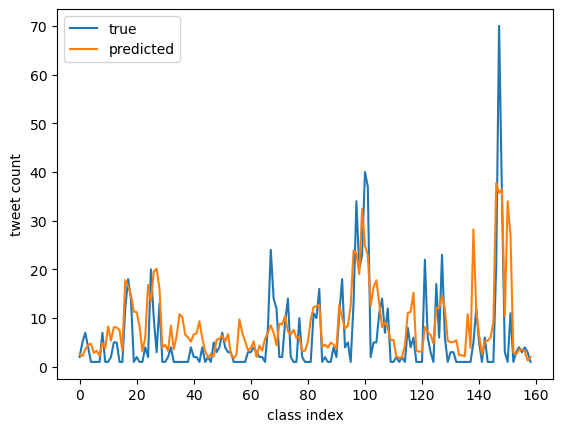

In [32]:
plt.plot(y_test.reset_index(drop=True), label='true');
plt.plot(y_pred, label='predicted');
plt.xlabel("class index");
plt.ylabel("tweet count");
plt.legend();

As discussed before, most peaks are underestimated